This is a notebook made using the Kaggle scikit-learn tutorial.

In [1]:
#importing packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns 
%matplotlib inline

# Importing csv files
# Input data files are available in the "../input/" directory.
train = pd.read_csv("../input/train.csv") 
test = pd.read_csv("../input/test.csv")
train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
304,305,0,3,"Williams, Mr. Howard Hugh ""Harry""",male,NaN,0,0,A/5 2466,8.0500,NaN,S
849,850,1,1,"Goldenberg, Mrs. Samuel L (Edwiga Grabowska)",female,NaN,1,0,17453,89.1042,C92,C
584,585,0,3,"Paulner, Mr. Uscher",male,NaN,0,0,3411,8.7125,NaN,C
743,744,0,3,"McNamee, Mr. Neal",male,24.0,1,0,376566,16.1000,NaN,S
350,351,0,3,"Odahl, Mr. Nils Martin",male,23.0,0,0,7267,9.2250,NaN,S


**Data preprocessing**

In [2]:
from sklearn import preprocessing
def encode_features(df_train, df_test): #label encoding for sklearn algorithms
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test

def simplify_ages(df): # Binning ages 
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df): # Storing first letter of cabins
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df): # Binning fares
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df): # Keeping title
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    
    
def drop_features(df): # Dropping useless features
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

train = transform_features(train)
test = transform_features(test)
train_vis = train.copy(deep=True) # data for visualization
train, test = encode_features(train, test)
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,7,0,0,0,7,329,16
3,4,1,1,0,7,1,0,3,2,267,20
4,5,0,3,1,7,0,0,1,7,15,19


**Data Visualization**

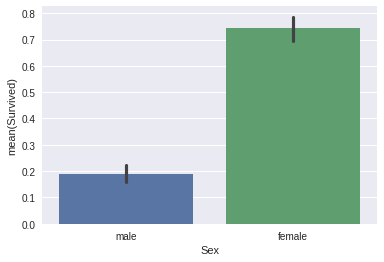

In [3]:
sns.barplot(x="Sex", y="Survived", data=train_vis)

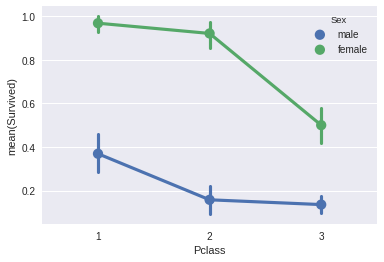

In [4]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=train_vis)

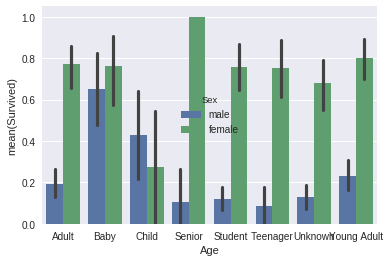

In [5]:
sns.barplot(x="Age", y="Survived", hue="Sex", data=train_vis)

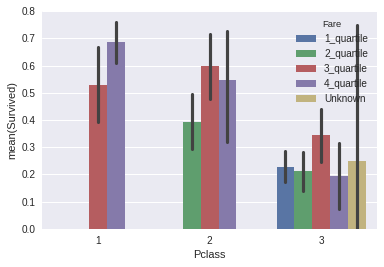

In [6]:
sns.barplot(x="Pclass", y="Survived", hue="Fare", data=train_vis)

**Setting up training and testing data**

In [7]:
from sklearn.model_selection import train_test_split

X_all = train.drop(['Survived', 'PassengerId'], axis=1)
y_all = train['Survived']

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=23)

**Fiting and tuning an algorithm**

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [9]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.810055865922


**Validating with K-fold**

In [10]:
from sklearn.cross_validation import KFold

def run_kfold(clf):
    kf = KFold(891, n_folds=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf:
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(clf)

Fold 1 accuracy: 0.7444444444444445
Fold 2 accuracy: 0.8651685393258427
Fold 3 accuracy: 0.7752808988764045
Fold 4 accuracy: 0.8539325842696629
Fold 5 accuracy: 0.8539325842696629
Fold 6 accuracy: 0.8089887640449438
Fold 7 accuracy: 0.7865168539325843
Fold 8 accuracy: 0.7865168539325843
Fold 9 accuracy: 0.8539325842696629
Fold 10 accuracy: 0.8202247191011236
Mean Accuracy: 0.8148938826466917


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


**Predicting on test data**

In [11]:
ids = test['PassengerId']
predictions = clf.predict(test.drop('PassengerId', axis=1))


output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.to_csv('titanic-predictions.csv', index = False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
